# Convolution Autoencoder
- CNN

## 1. Import Libs

In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as dset
from torch.utils.data import DataLoader

import itertools
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

USE_CUDA = torch.cuda.is_available()

## 2. Load Dataset

In [2]:
model_dir = './save_models/MNIST/Conv_Autoencoder'

if not os.path.exists(model_dir):
    os.mkdir(model_dir)

mnist_train = dset.MNIST('./data/MNIST', train=True, transform=transforms.ToTensor(), target_transform=None,download=True)
mnist_test = dset.MNIST('./data/MNIST', train=False, transform=transforms.ToTensor(), target_transform=None,download=True)

batch_size = 100

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

## 3. Build Model
- encoder
- decoder

In [3]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), # batch_size x 16 x 28 x 28
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, 3, padding=1), # batch_size x 32 x 28 x 28
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, padding=1), # batch_size x 64 x 28 x 28
            nn.ReLU(),
            nn.BatchNorm2d(64), # batch_size x 64 x 14 x 14
            nn.MaxPool2d(2, 2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1), # batch_size x 128 x 14 x 14
            nn.ReLU(),
            nn.BatchNorm2d(128), 
            nn.MaxPool2d(2, 2), # batch_size x 128 x 7 x 7
            nn.Conv2d(128, 256, 3, padding=1), #  batch_size x 256 x 7 x 7
            nn.ReLU()
        )
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size, -1)
        return out

![](./asset/ConvTranspose2d.png)

In [4]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, 2, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(64, 16, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 1, 3, 2, 1, 1),
            nn.ReLU()
        )
        
    def forward(self, inputs):
        batch_size = inputs.size(0)
        
        out = inputs.view(batch_size, 256, 7, 7)
        out = self.layer1(out)
        out = self.layer2(out)
        return out

In [5]:
encoder = Encoder()
decoder = Decoder()

if USE_CUDA:
    encoder = encoder.cuda()
    decoder = decoder.cuda()

## 4. Loss Func & Optims

In [6]:
parameters = itertools.chain(encoder.parameters(), decoder.parameters())
loss_func = nn.MSELoss()
optimizer = optim.Adam(parameters, lr=0.0002)

In [7]:
try:
    encoder, decoder = torch.load(model_dir + '/conv_autoencoder.pkl')
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass


--------model not restored--------



## 5. Train

In [8]:
num_epoch = 10

for i in range(num_epoch):
    for j, (image, label) in enumerate(train_loader):
        optimizer.zero_grad()
        
        if USE_CUDA:
            image = image.cuda()
        
        z = encoder(image)
        output = decoder(z)
        loss = loss_func(output, image)
        
        loss.backward()
        optimizer.step()
        
        if j % 10 == 0:
            torch.save([encoder,decoder], model_dir + '/conv_autoencoder.pkl')
            
    print("[%d/%d] MSE_loss : %0.5f"%(i+1, num_epoch, loss.item()))

/home/paulkim/anaconda3/envs/pytorch02/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/paulkim/anaconda3/envs/pytorch02/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


[1/10] MSE_loss : 0.00190
[2/10] MSE_loss : 0.00126
[3/10] MSE_loss : 0.00100
[4/10] MSE_loss : 0.00079
[5/10] MSE_loss : 0.00071
[6/10] MSE_loss : 0.00052
[7/10] MSE_loss : 0.00048
[8/10] MSE_loss : 0.00046
[9/10] MSE_loss : 0.00040
[10/10] MSE_loss : 0.00045


## 6. Check Train Image

<built-in method size of Tensor object at 0x7f2ed04b04c8>


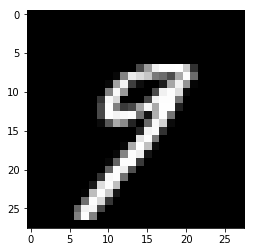

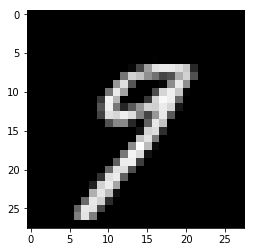

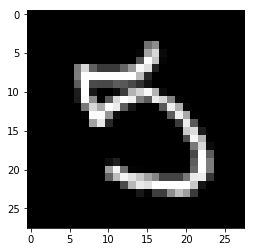

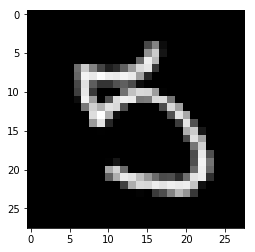

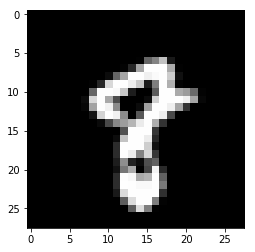

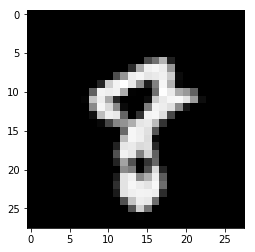

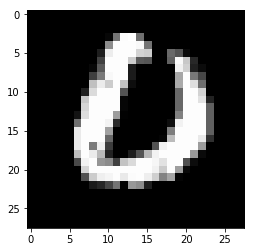

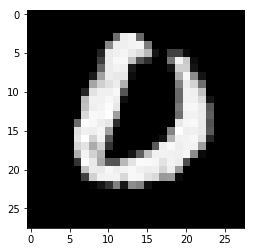

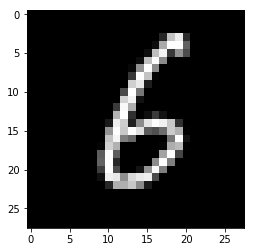

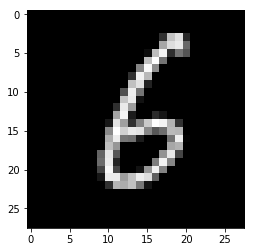

In [9]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size)

for i in range(5):
    plt.imshow(torch.squeeze(image[i].cpu()).numpy(), cmap='gray')
    plt.show()
    plt.imshow(out_img[i].numpy(), cmap='gray')
    plt.show()

## 7. Check Test Image

In [10]:
for i in range(1):
    for j, (image, label ) in enumerate(test_loader):
        if USE_CUDA:
            image= image.cuda()
        
        z = encoder(image)
        output = decoder(z)
        
        if j% 10 == 0:
            print("MSE_loss : %0.5f"%(loss.item()))
            
    print("MSE_loss : %0.5f"%(loss.item()))

MSE_loss : 0.00045
MSE_loss : 0.00045
MSE_loss : 0.00045
MSE_loss : 0.00045
MSE_loss : 0.00045
MSE_loss : 0.00045
MSE_loss : 0.00045
MSE_loss : 0.00045
MSE_loss : 0.00045
MSE_loss : 0.00045
MSE_loss : 0.00045


torch.Size([100, 28, 28])


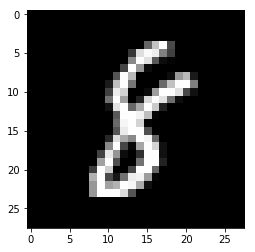

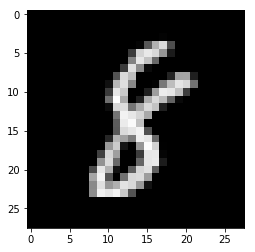

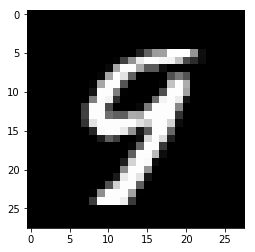

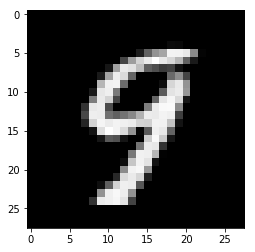

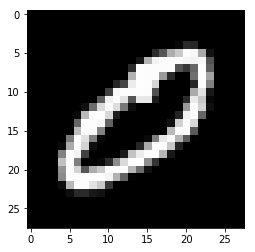

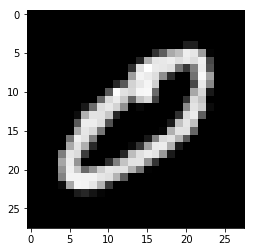

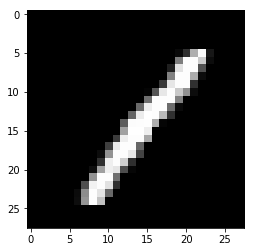

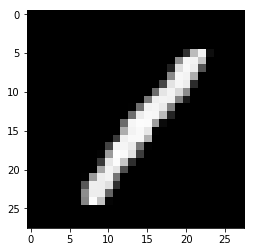

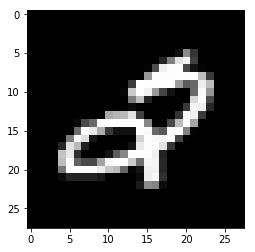

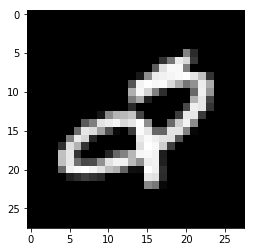

In [11]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(5):
    plt.imshow(torch.squeeze(image[i].cpu()).data.numpy(), cmap='gray')
    plt.show()
    plt.imshow(out_img[i].numpy(), cmap='gray')
    plt.show()